# Generate Topic Data

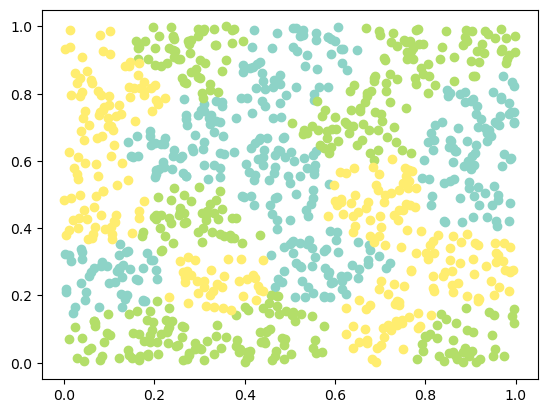

In [1]:
import sys
import os
import numpy as np
from numpy.linalg import norm, svd, solve, qr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx

import scipy
from scipy.sparse import csr_matrix
from scipy.optimize import linear_sum_assignment

import cvxpy as cp
from cvxpy import Variable
from cvxpy.problems.objective import Minimize
from cvxpy.problems.problem import Problem

sys.path.append('./SpLSI/pycvxcluster/src/')
import pycvxcluster.pycvxclt

from SpLSI import generate_topic_model as gen_model
from SpLSI.utils import *
from SpLSI.spatialSVD import *
from SpLSI import splsi
#from netgraph import Graph
#from netgraph import get_sugiyama_layout

N = 100 # doc length
n = 1000 # number of nodes
p = 30 # vocab size
K = 3 # number of topics
r = 0.05 # heterogeneity parameter
m = 5 # number of neighbors to be considered in weights
phi = 0.1 # weight parameter

np.random.seed(127)
df, W, A, D = gen_model.generate_data(N, n, p , K, r)
gen_model.plot_scatter(df)

# MST Folds / Matrix Denoising via Iterative Convex Clustering

In [2]:
weights = gen_model.generate_weights(df, K, m, phi)
G, mst, path = generate_mst(df, weights, n)
srn, fold1, fold2 = get_folds(mst, path, n, plot_tree=False)
folds = {0:fold1, 1:fold2}

Source node is 511


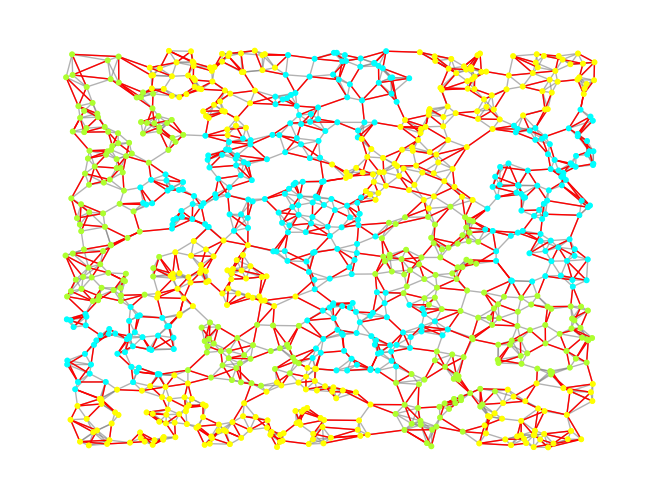

In [3]:
colors = gen_model.get_colors(df)
# Plot the random graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=10, node_color=colors, edge_color='gray', alpha=0.6)

# Plot the minimum spanning tree in red
nx.draw(mst, pos, with_labels=False, node_size=10, node_color=colors, edge_color='r', alpha=1)

plt.show()

# Spatial pLSI

#### Test SpatialSVD

In [20]:
lambds = (0.0005*np.power(1.15, np.arange(10))).tolist()
lambds

[0.0005,
 0.000575,
 0.0006612499999999999,
 0.0007604374999999999,
 0.0008745031249999997,
 0.0010056785937499998,
 0.0011565303828124996,
 0.0013300099402343744,
 0.0015295114312695304,
 0.0017589381459599599]

### Spatial SVD

In [22]:
spl = splsi.SpLSI(lamb_start = 0.0005,
              step_size = 1.15,
              grid_len = 10,)
spl.fit(D, K, df, weights)

Running spatial SVD...
Source node is 321


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Error is 0.4441578045545317
Error is 0.021488015650505933
Error is 0.0002816510533751224
Error is 6.811666258049151e-06
Error is 2.11702321125389e-07
Running SPOC...


Error is 6.984104135291306.
Accuracy is 0.895.


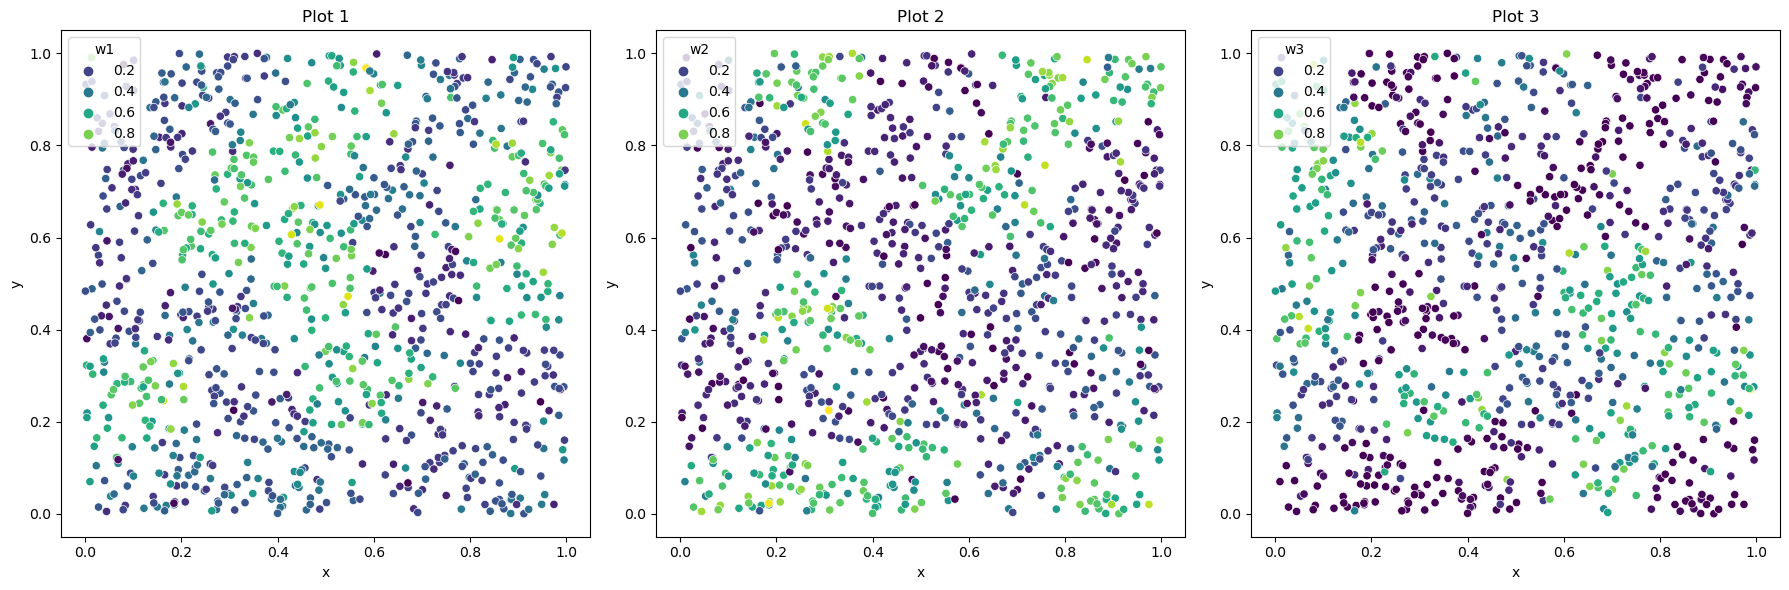

In [23]:
W_hat = spl.W_hat
P = get_component_mapping(W_hat.T, W)
W_hat = W_hat @ P
err = get_F_err(W_hat, W)
acc = get_accuracy(df, n, W_hat)
print(f"Error is {err}.")
print(f"Accuracy is {acc}.")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for j, ax in enumerate(axes):
    w = W_hat[:, j]
    df[f'w{j+1}'] = w
    sns.scatterplot(x='x', y='y', hue=f'w{j+1}', data=df, palette='viridis', ax=ax)
    ax.set_title(f'Plot {j+1}')
plt.tight_layout()
plt.show()

### Vanilla SVD

In [7]:
spl_v = splsi.SpLSI(lamb_start = 0.01,
              step_size = 1.5,
              grid_len = 10,
              method = "nonspatial")
spl_v.fit(D, K, df, weights)

Running vanilla SVD...
Running SPOC...


Error is 8.094953781520399.
Accuracy is 0.882.


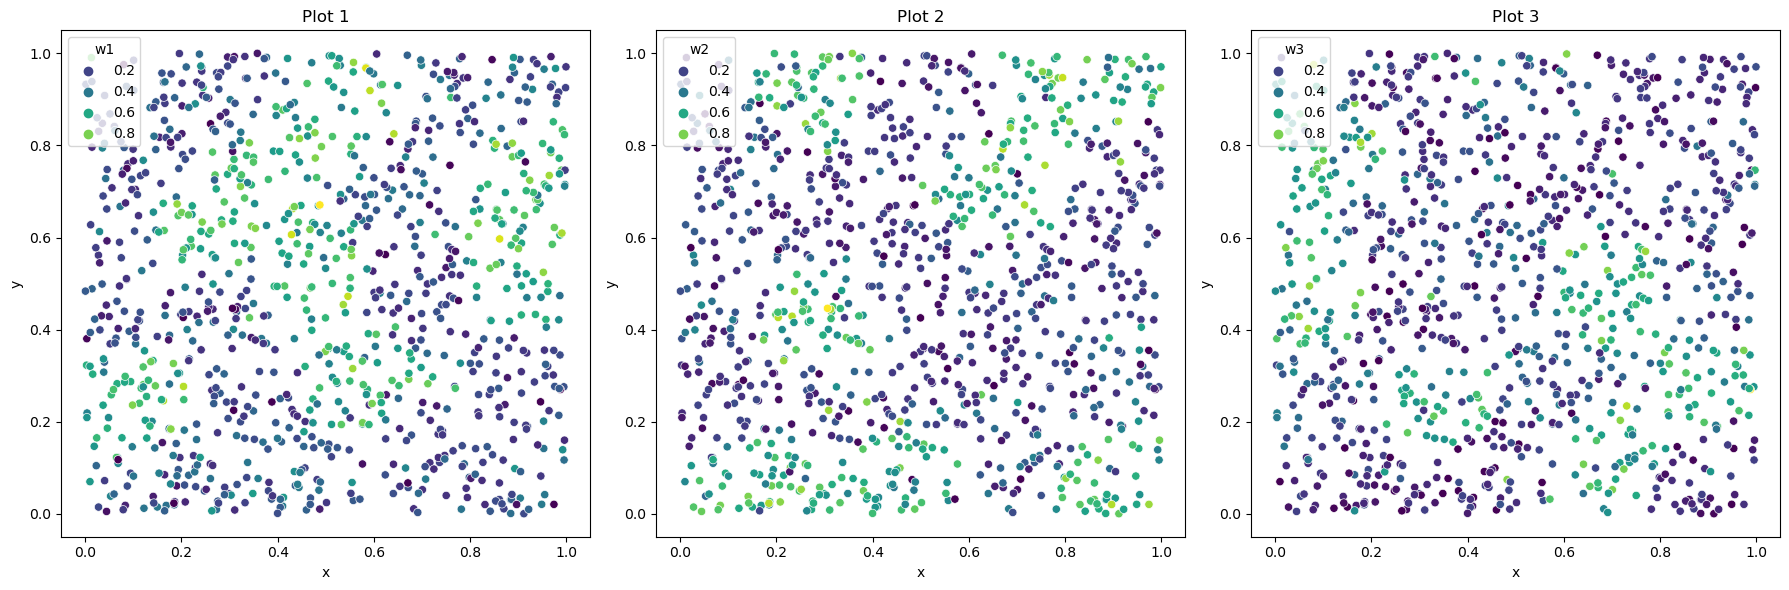

In [8]:
W_hat = spl_v.W_hat
P = get_component_mapping(W_hat.T, W)
W_hat = W_hat @ P
err = get_F_err(W_hat, W)
acc = get_accuracy(df, n, W_hat)
print(f"Error is {err}.")
print(f"Accuracy is {acc}.")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for j, ax in enumerate(axes):
    w = W_hat[:, j]
    df[f'w{j+1}'] = w
    sns.scatterplot(x='x', y='y', hue=f'w{j+1}', data=df, palette='viridis', ax=ax)
    ax.set_title(f'Plot {j+1}')
plt.tight_layout()
plt.show()

### Ground Truth

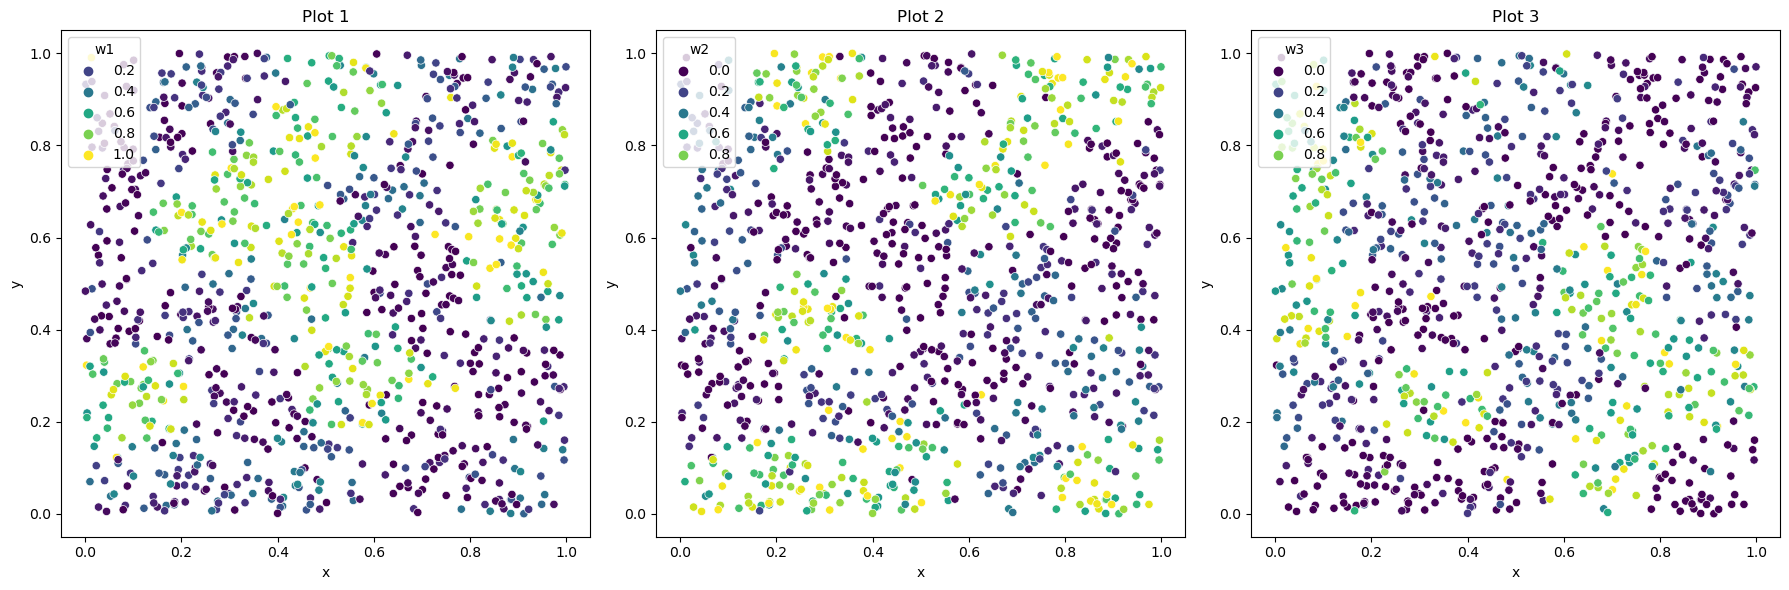

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for j, ax in enumerate(axes):
    w = W[j,:]
    df[f'w{j+1}'] = w
    sns.scatterplot(x='x', y='y', hue=f'w{j+1}', data=df, palette='viridis', ax=ax)
    ax.set_title(f'Plot {j+1}')
plt.tight_layout()
plt.show()